<a href="https://colab.research.google.com/github/werlang/emolearn-ml-model/blob/main/conv3d_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.engine import  Model
from keras.models import Sequential, load_model
from keras.layers import TimeDistributed, GRU, LSTM, Dropout, Conv2D, Conv3D, BatchNormalization, MaxPooling2D, MaxPooling3D, Flatten, Dense, Input
from keras.utils import Sequence, plot_model, to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, Callback, ModelCheckpoint
from keras.metrics import AUC
import pandas as pd
import numpy as np
import os, cv2
import datetime
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from keras import backend as K
import math
from IPython.display import Image

def start_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    !pip install Keras-Applications


def extract_data():
    !mkdir features

    # aligned faces extracted from openface
    print("COPYING TRAIN SET...")
    !unzip -n -q "drive/My Drive/Doutorado/Implementação/new_features_daisee/Train.zip" -d features 
    print("COPYING TEST SET...")
    !unzip -n -q "drive/My Drive/Doutorado/Implementação/new_features_daisee/Test.zip" -d features 
    print("COPYING VALIDATION SET...")
    !unzip -n -q "drive/My Drive/Doutorado/Implementação/new_features_daisee/Validation.zip" -d features 
    print("COPYING LABELS...")
    !cp -r "drive/My Drive/Doutorado/Implementação/new_features_daisee/labels" ./
    print("DONE")


class Generator_V(Sequence):
    def __init__(self, split, batch_size, frames, **kw):
        self.batch_size = batch_size 
        self.split = split

        Y = np.load("{}/{}.npy".format(labels_path, split))
        Y_gen = to_categorical(Y, 2)

        self.labels, self.videos = [], []
        interval = 2
        stride = 0.5
        fps = 15
        skip = int(round(interval * fps / frames, 0))

        for Yi in range(len(Y_gen)):
            dir_path = "{}/{}/{}".format(features_path, split, Yi)
            files = []
            for r, d, f in os.walk(dir_path):
                for i in f:
                    files.append("{}/{}".format(r, i))

            for i in range(0, (len(files) - frames*skip) // skip + 1, np.max([1, int(stride * frames)])):
                temp = []
                for j in range(i*skip, (i+frames)*skip, skip):
                    temp.append(files[j])
                self.videos.append(temp)
                self.labels.append(Y_gen[Yi])

    def __len__(self):
        return int(np.ceil(len(self.videos) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.videos[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        videos = []
        for video in batch_x:
            images = []
            for name in video:
                images.append(cv2.imread(name))
            videos.append(np.array(images)/255)

        videos = np.array(videos)
        label = np.array(batch_y)

        return videos, label


def build_model():
    ########### IF BUILT, MUST DEFINE A NAME TO APPEND TO DIRECTORY NAME ###############
    ident_name = 'conv3d-1st-try'

    ########### IF LOADED, MUST DEFINE DIR NAME AND STARTING EPOCH ############
    dir_name = '2020-7-16-21-51-7-fine-tune-images-vgg-gru-striding-2'

    input = Input(shape=(time_frames,224,224,3))
    x = Conv3D(4, kernel_size=(3, 3, 3), activation='relu')(input)
    x = Conv3D(8, kernel_size=(3, 3, 3), activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = Conv3D(16, kernel_size=(3, 3, 3), padding="same", activation='relu')(x)
    x = Conv3D(32, kernel_size=(3, 3, 3), padding="same", activation='relu')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input, x)

    model.compile(
        loss='categorical_crossentropy',
        # optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True), 
        optimizer = Adam(lr=1e-4),
        metrics=['accuracy'])

    #showing the model

    # print("GRU:")
    # for layer in model.layers:
    #     print("{} {}".format(layer.output.shape.as_list(), layer.trainable))

    # model.summary()

    plot_model(model, show_layer_names=False, show_shapes=True)

    loadModel = False if epoch == 0 else True

    if not loadModel:
        t = datetime.datetime.now()
        prefix = str(t.year) +'-'+ str(t.month) +'-'+ str(t.day) +'-'+ str(t.hour) +'-'+ str(t.minute) +'-'+ str(t.second)
        save_dir = "{}/{}-{}".format(drive_save_path, prefix, ident_name)
        os.mkdir(save_dir)
    else:
        file_name = "{:03d}.h5".format(epoch)
        save_dir = "{}/{}".format(drive_save_path, dir_name)
        print("Loading model from {}/{}.".format(save_dir, file_name))
        model = load_model("{}/{}".format(save_dir, file_name))

    return model, save_dir, epoch


def set_callbacks():
    #callbacks
    checkpoint = ModelCheckpoint(
        filepath = save_dir + '/{epoch:03d}.h5', 
        monitor = 'val_loss', 
        verbose=1, 
        save_best_only=True,
    )

    tensorboard = TensorBoard(
    	log_dir         = "{}/logs".format(save_dir),
    	histogram_freq  = 0,
    	write_graph     = True,
    	write_grads     = False,
    	write_images    = True
    )

    early_stop = EarlyStopping(
        monitor 	= 'val_loss',
        patience 	= 10,
        restore_best_weights = True,
        verbose     = 1,
        min_delta   = 1e-5
    )

    reduce_lr_plateau = ReduceLROnPlateau(
        monitor 	= 'val_loss',
        factor		= 0.2,
        patience	= 5,
        min_lr		= 1e-8,
        verbose     = 1
    )

    return [checkpoint, early_stop, reduce_lr_plateau]


def build_generators():
    #build the data generators
    print("Building generators...")
    gen_train = Generator_V('Train', batch_size, time_frames)
    gen_val = Generator_V('Validation', batch_size, time_frames)
    print("DONE")

    return gen_train, gen_val


def fit_model():
    #calculate weights based on train set distribution
    label_array = np.load("{}/Train.npy".format(labels_path))
    class_ratio = np.sum(label_array) / len(label_array)
    weights = {0: class_ratio, 1: 1 - class_ratio}

    def run():
        #run the model
        model.fit_generator(
            gen_train,
            epochs = 1000,
            validation_data = gen_val,
            class_weight = weights,
            callbacks = callbacks,
            initial_epoch = epoch)
        
    run()  


def predict():
    print("Preparing data...")
    gen_test = Generator_V('Test', batch_size, time_frames)

    def get_Y_true():
        Y = np.load("{}/Test.npy".format(labels_path))

        labels = []
        vtime = 10
        interval = 2
        stride = 0.5
        n_videos = int((vtime / interval - 1) / stride + 1)
        
        for Yi in range(len(Y)):    
            for i in range(n_videos):
                labels.append(Y[Yi])
        
        return np.array(labels)

    Y_true = get_Y_true()
   
    print("Predicting...")
    Y_pred = (model.predict(gen_test, verbose=1)).argmax(axis=1)
    print("Confusion matrix:\n")
    cm = confusion_matrix(Y_true, Y_pred)
    print(cm)

    print("Evaluating...")
    ev = model.evaluate(gen_test, verbose=1)
    print("\nLoss: {}, Acc: {}".format(ev[0], ev[1]))

        

Building generators...
DONE


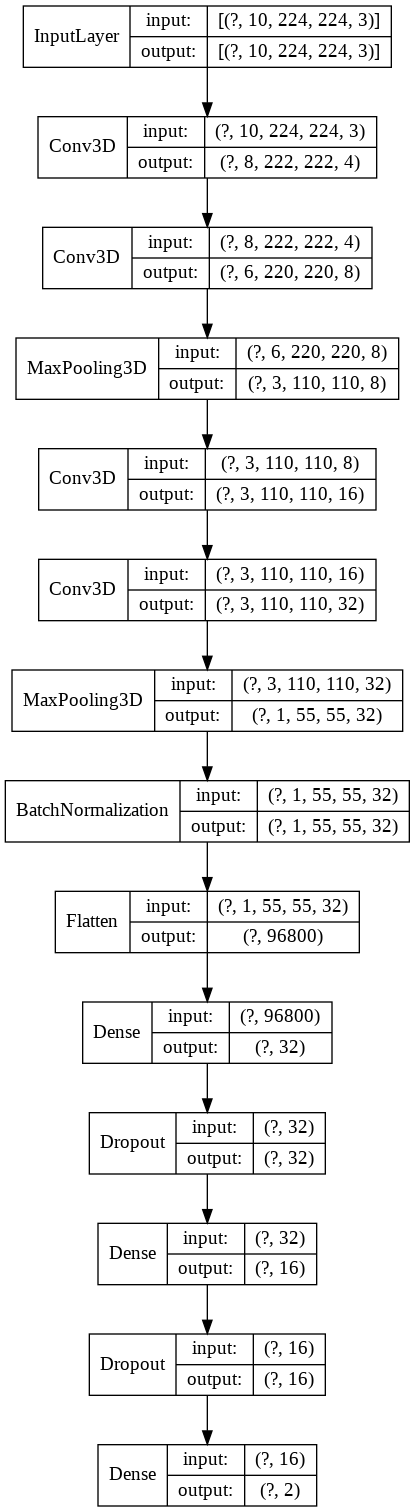

In [ ]:
labels_path = "labels"
features_path = "features"
drive_save_path = 'drive/My Drive/1NOSYNC/DT/checkpoint'
batch_size = 20
labels = ['Test', 'Train', 'Validation']
time_frames = 10
epoch = 0

# start_colab()
# extract_data()

# gen_train, gen_val = build_generators()
model, save_dir, epoch = build_model()
callbacks = set_callbacks()
fit_model()
# predict()